# Feature Engineering

In this notebook I will show and create a pipeline that can clean different datasets for a classification or a regression machine learning model.

#### Classification

In this demo, I will bring together various techniques for feature engineering that to tackle a classification problem. This is an end-to-end project pipeline that we can use to build machine learning algorithms for classification.

I will:
- build a gradient boosted tree
- use feature-engine for the feature engineering steps
- set up an entire engineering and prediction pipeline using a Scikit-learn Pipeline

============================================================================

I will use the titanic dataset as it provides a lot of common problems that we can tackle.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

In [3]:
# load dataset

cols = [
    'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
    'embarked', 'survived'
]

data = pd.read_csv('titanic.csv', usecols=cols)
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked
0,1,1,female,29.0000,0,0,211.3375,B5,S
1,1,1,male,0.9167,1,2,151.5500,C22,S
2,1,0,female,2.0000,1,2,151.5500,C22,S
3,1,0,male,30.0000,1,2,151.5500,C22,S
4,1,0,female,25.0000,1,2,151.5500,C22,S


In [4]:
# Types of variables:
data.dtypes

pclass        int64
survived      int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
dtype: object

In [5]:
# Let's inspect the variable values
for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

pclass [1 2 3] 

survived [1 0] 

sex ['female' 'male'] 

age [29.      0.9167  2.     30.     25.     48.     63.     39.     53.
 71.     47.     18.     24.     26.     80.         nan 50.     32.
 36.     37.    ] 

sibsp [0 1 2 3 4 5 8] 

parch [0 2 1 4 3 5 6 9] 

fare [211.3375 151.55    26.55    77.9583   0.      51.4792  49.5042 227.525
  69.3     78.85    30.      25.925  247.5208  76.2917  75.2417  52.5542
 221.7792  26.      91.0792 135.6333] 

cabin ['B5' 'C22' 'E12' 'D7' 'A36' 'C101' nan 'C62' 'B35' 'A23' 'B58' 'D15' 'C6'
 'D35' 'C148' 'C97' 'B49' 'C99' 'C52' 'T'] 

embarked ['S' 'C' nan 'Q'] 



There are continuous and discrete variables in the dataset.

In [6]:
# We can make some lists of the different variables

# numerical: discrete vs continuous
discrete = [var for var in data.columns if data[var].dtype!='O' and var!='survived' and data[var].nunique()<10]
continuous = [var for var in data.columns if data[var].dtype!='O' and var!='survived' and var not in discrete]

# mixed
mixed = ['cabin']

# categorical
categorical = [var for var in data.columns if data[var].dtype=='O' and var not in mixed]

print('There are {} discrete variables'.format(len(discrete)))
print('There are {} continuous variables'.format(len(continuous)))
print('There are {} categorical variables'.format(len(categorical)))
print('There are {} mixed variables'.format(len(mixed)))

There are 3 discrete variables
There are 2 continuous variables
There are 2 categorical variables
There are 1 mixed variables


In [8]:
# Let check for missing values in %
data.isnull().mean()

pclass      0.000000
survived    0.000000
sex         0.000000
age         0.200917
sibsp       0.000000
parch       0.000000
fare        0.000764
cabin       0.774637
embarked    0.001528
dtype: float64

There are missing values in our dataset. Let tackle that in our pipeline

In [9]:
# Cardinality (number of different categories)
data[categorical+mixed].nunique()

sex           2
embarked      3
cabin       181
dtype: int64

"Cabin" got a lot of variables which makes it highly cardinal.

<AxesSubplot:>

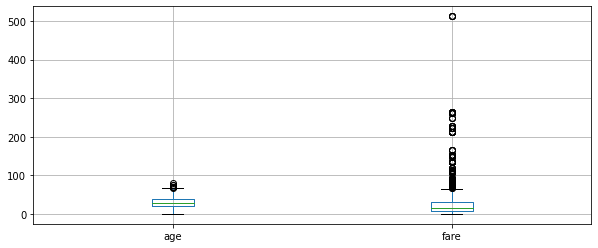

In [10]:
# Let's have a look at the outliers of the continuous variables 
data[continuous].boxplot(figsize=(10,4))

<AxesSubplot:>

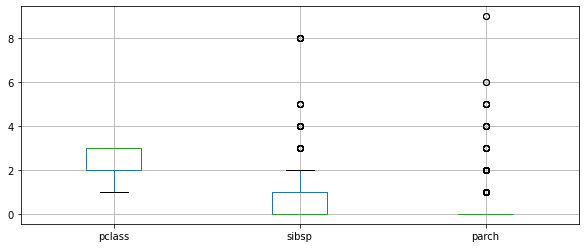

In [11]:
# Outliers in discrete
data[discrete].boxplot(figsize=(10,4))

In [12]:
# Values bigger than 3 are rare for parch
data['parch'].value_counts()

0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: parch, dtype: int64

In [13]:
# Feature magnitude
data.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


Features are in different ranges or scales. But this is not relevant for gradient boosted trees. 

In [15]:
# Since the "Cabin" is a mixed varible with strings and number, we should split the variable into two.
data['cabin_num'] = data['cabin'].str.extract('(\d+)') # captures numerical part
data['cabin_num'] = data['cabin_num'].astype('float')
data['cabin_cat'] = data['cabin'].str[0] # captures the first letter

# We can remove the original mixed variable.
data.drop(['cabin'], axis=1, inplace=True)

# show dataframe
data.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,cabin_num,cabin_cat
0,1,1,female,29.0000,0,0,211.3375,S,5.0,B
1,1,1,male,0.9167,1,2,151.5500,S,22.0,C
2,1,0,female,2.0000,1,2,151.5500,S,22.0,C
3,1,0,male,30.0000,1,2,151.5500,S,22.0,C
4,1,0,female,25.0000,1,2,151.5500,S,22.0,C


In [16]:
# Separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('survived', axis=1),  # predictors
    data['survived'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1178, 9), (131, 9))

In [19]:
# Check for cardinality again after cleaning of "cabin"
X_train[['cabin_cat', 'sex', 'embarked']].nunique()

cabin_cat    8
sex          2
embarked     3
dtype: int64

In [20]:
# Check variable frequency

var = 'cabin_cat'
(X_train[var].value_counts() / len(X_train)).sort_values()

T    0.000849
G    0.003396
A    0.016978
F    0.016978
E    0.033107
D    0.033956
B    0.049236
C    0.073854
Name: cabin_cat, dtype: float64

Cabin T and G appear only in a few oberservations, so I will replace them into rare.

In [17]:
# We can take a look at the % of missing data for the numerical variables.

X_train.select_dtypes(exclude='O').isnull().mean()

pclass       0.000000
age          0.198642
sibsp        0.000000
parch        0.000000
fare         0.000849
cabin_num    0.782683
dtype: float64

In [18]:
# Categorical missing values
X_train.select_dtypes(include='O').isnull().mean()

sex          0.000000
embarked     0.001698
cabin_cat    0.771647
dtype: float64

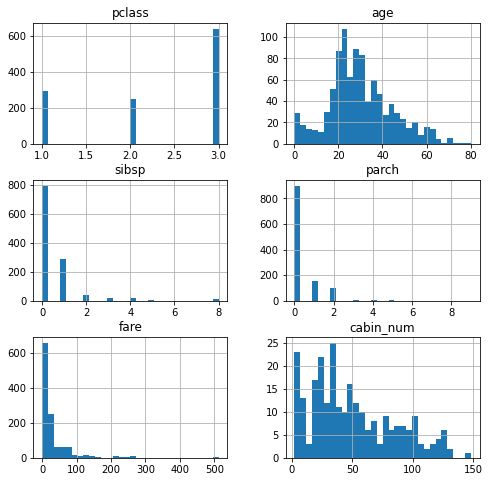

In [21]:
# Let's explore the distribusion of the numerical variables.

X_train.select_dtypes(exclude='O').hist(bins=30, figsize=(8,8))
plt.show()

In [22]:
titanic_pipe = Pipeline([

    # Missing data imputation for numeric variables.
    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1,
                                variables=['age', 'fare', 'cabin_num'])),
    # Missing values for categorical variables.
    ('imputer_cat',
     mdi.CategoricalImputer(variables=['embarked', 'cabin_cat'])),

    # categorical encoding for rare labels.
    ('encoder_rare_label',
     ce.RareLabelEncoder(tol=0.01,
                                    n_categories=6,
                                    variables=['cabin_cat'])),
    # Categorical encoder for ordinal variables.
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                                  variables=['cabin_cat', 'sex', 'embarked'])),

    # Gradient Boosted machine
    ('gbm', GradientBoostingClassifier(random_state=0))
])

In [23]:
# let's fit the pipeline and make predictions
titanic_pipe.fit(X_train, y_train)

X_train_preds = titanic_pipe.predict_proba(X_train)[:,1]
X_test_preds = titanic_pipe.predict_proba(X_test)[:,1]

In [24]:
# a peek into the prediction values
X_train_preds

array([0.27876558, 0.08146821, 0.46816053, ..., 0.70745459, 0.90809699,
       0.4980871 ])

In [27]:
print('Train set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_train, X_train_preds)))

print('Test set')
print('GBM roc-auc: {}'.format(roc_auc_score(y_test, X_test_preds)))

Train set
GBM roc-auc: 0.9269576293912577
Test set
GBM roc-auc: 0.8396084337349397


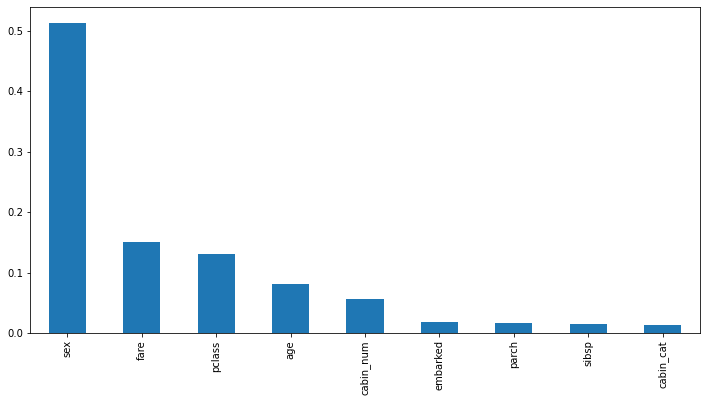

In [30]:
# Let's explore the importance of the features

importance = pd.Series(titanic_pipe.named_steps['gbm'].feature_importances_)
importance.index = data.drop('survived', axis=1).columns
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(12,6))
plt.show()

#### Regression model

Now I want to create a pipeline for a regression model using lasso.

In [31]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

pd.pandas.set_option('display.max_columns', None)

In [35]:
# load dataset
path = r'C:\Users\ml258\Python\Feature Engineering\feature-engineering-for-machine-learning-master\house-prices-advanced-regression-techniques\houseprice.csv'
data = pd.read_csv(path)
print(data.shape)

data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [37]:
# Let's take a look at the types of data
data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [38]:
# We have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


In [39]:
# Find categorical variables

categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [40]:
data[categorical].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Find temporal variables

There are a few variables in the dataset that are temporal. They indicate the year in which something happened. We shouldn't use these variables straightaway for model building. We should instead transform them to capture some sort of time information. Let's inspect these temporal variables:

In [41]:
# Make a list of the numerical variables first
numerical = [var for var in data.columns if data[var].dtype!='O']

# List of variables that contain year information
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [42]:
data[year_vars].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


We can see that these variables correspond to the years in which the houses were built or remodeled or a garage was built, or the house was indeed sold. It would be better if we captured the time elapsed between the time the house was built and the time the house was sold for example. We are going to do that in the feature engineering section later in the notebook. 

We have another temporal variable: MoSold, which indicates the month in which the house was sold. Let's inspect if the house price varies with the time of the year in which it is sold:

Text(0, 0.5, 'median House price')

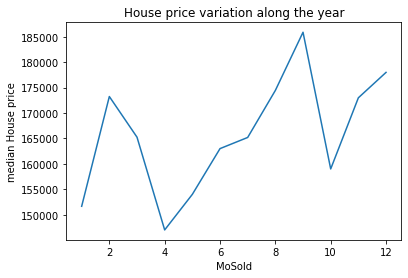

In [43]:
# plot median house price per month in which it was sold

data.groupby('MoSold')['SalePrice'].median().plot()
plt.title('House price variation along the year')
plt.ylabel('median House price')

The price seems to vary depending on the month in which the house is sold.

#### Find discrete variables

To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number of distinct values. See below.

In [44]:
# Let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20 and var not in year_vars:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]

There are 14 discrete variables


### Continous variables

In [45]:
# Let's find the continuous variables. We need to exclude ID and the dependent variable "SalePrice".

numerical = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 18 numerical and continuous variables


#### Missing values

In [46]:
# Let's output variables with NA and the percentage of NA

for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())

LotFrontage 0.1773972602739726
Alley 0.9376712328767123
MasVnrType 0.005479452054794521
MasVnrArea 0.005479452054794521
BsmtQual 0.025342465753424658
BsmtCond 0.025342465753424658
BsmtExposure 0.026027397260273973
BsmtFinType1 0.025342465753424658
BsmtFinType2 0.026027397260273973
Electrical 0.0006849315068493151
FireplaceQu 0.4726027397260274
GarageType 0.05547945205479452
GarageYrBlt 0.05547945205479452
GarageFinish 0.05547945205479452
GarageQual 0.05547945205479452
GarageCond 0.05547945205479452
PoolQC 0.9952054794520548
Fence 0.8075342465753425
MiscFeature 0.963013698630137


#### Outliers and distributions

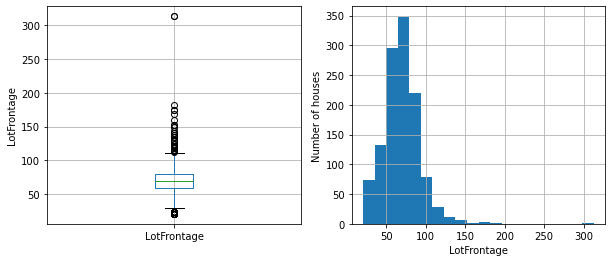

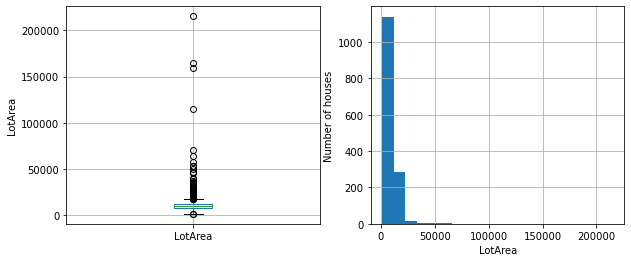

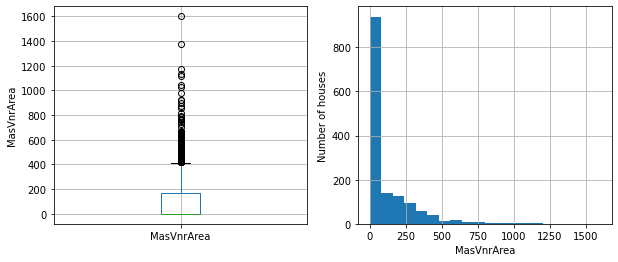

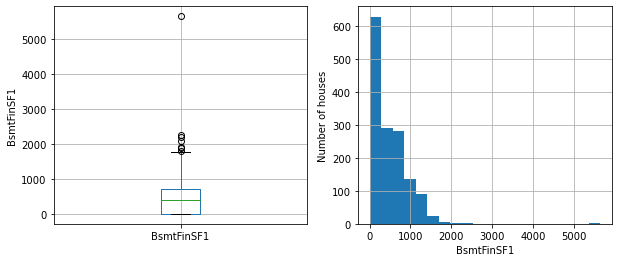

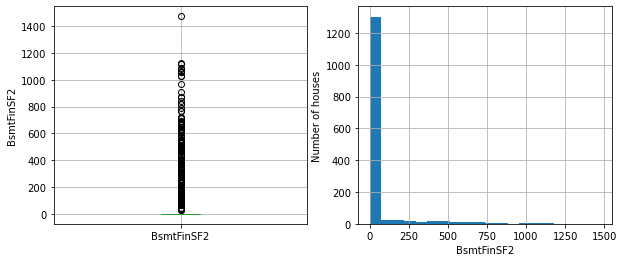

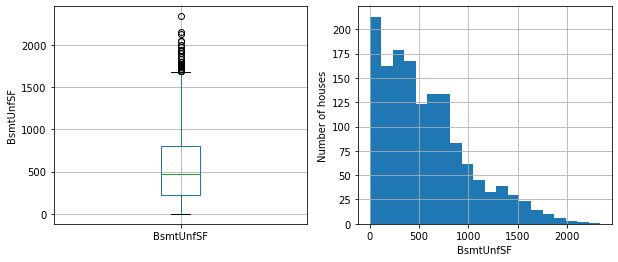

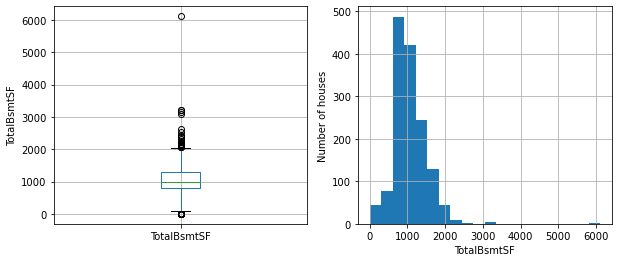

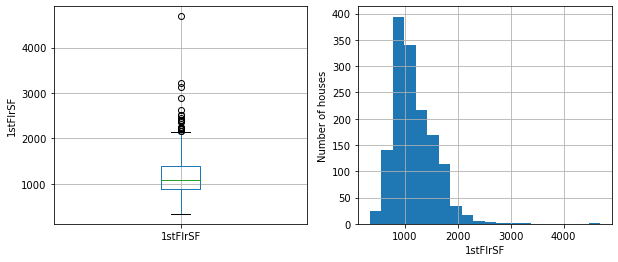

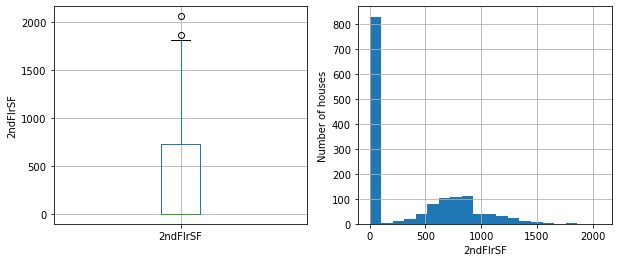

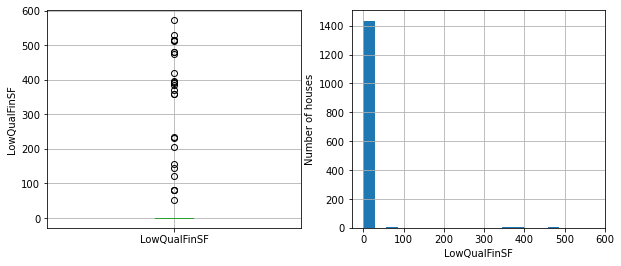

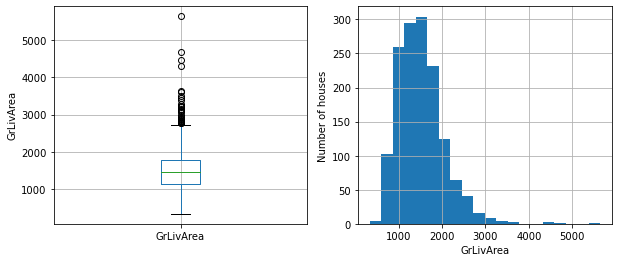

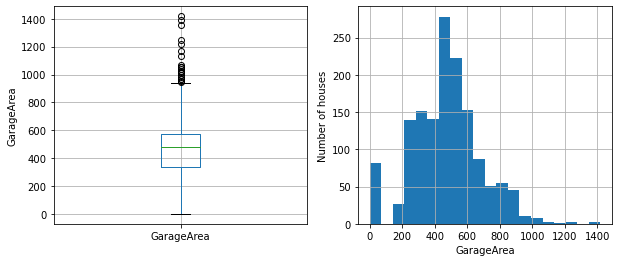

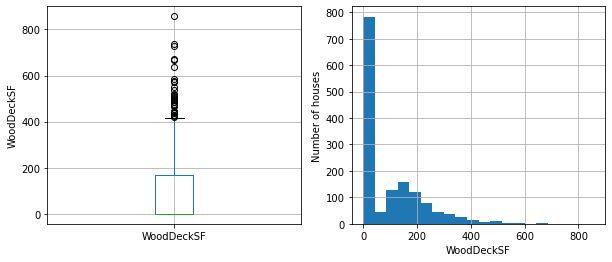

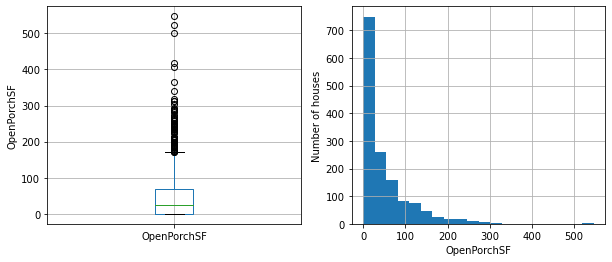

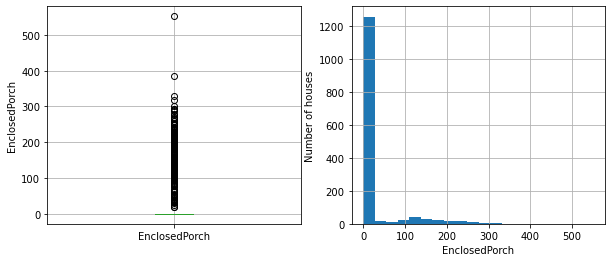

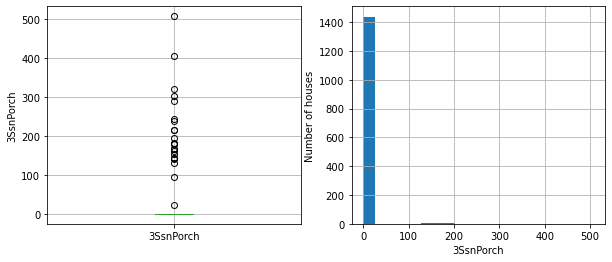

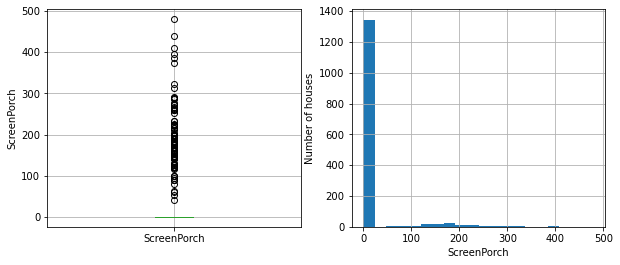

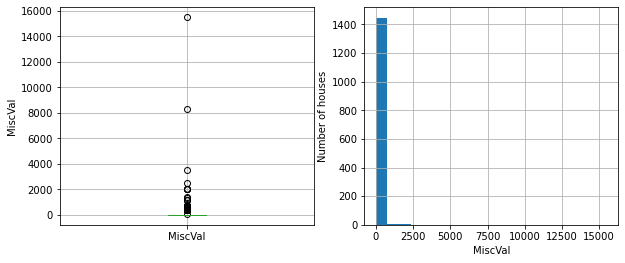

In [50]:
# Let's make boxplots to visualise outliers in the continuous variables and histograms to get an idea of the distribution.
for var in numerical:
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. As we are planning to build linear regression, we need to tackle these to improve the model performance. To tackle the 2 aspects together, I will do discretisation. I will follow discretisation with encoding of the intervals following the target mean.

#### Outliers in discrete variables

Now, let's identify outliers in the discrete variables. I will call outliers those values that are present in less than 5 % of the houses. This is exactly the same as finding rare labels in categorical variables.

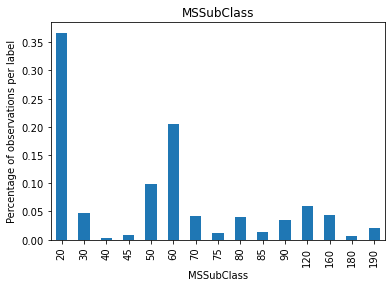

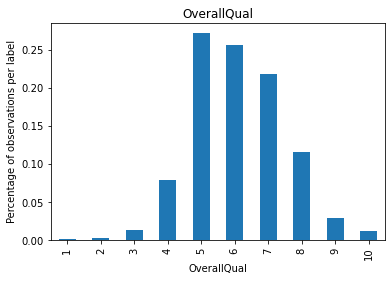

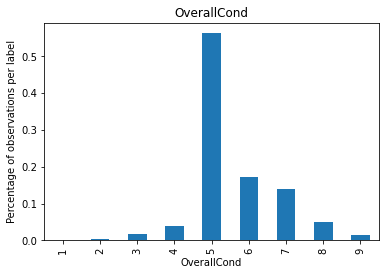

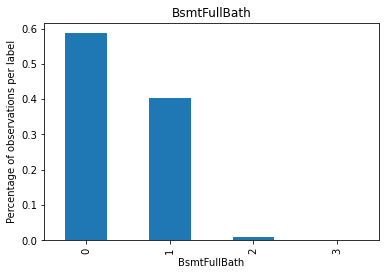

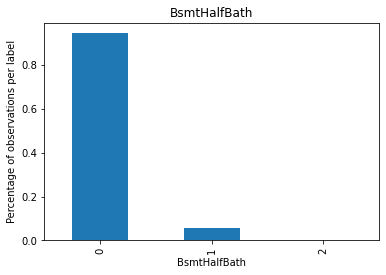

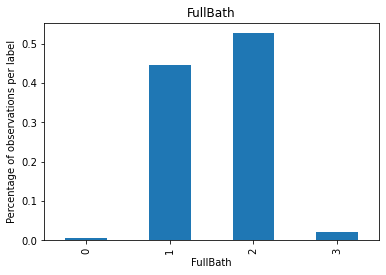

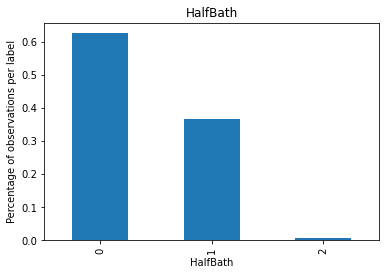

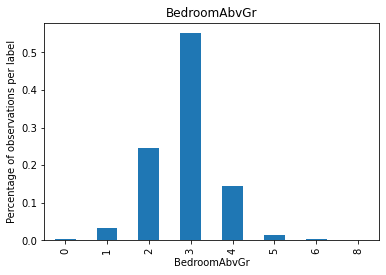

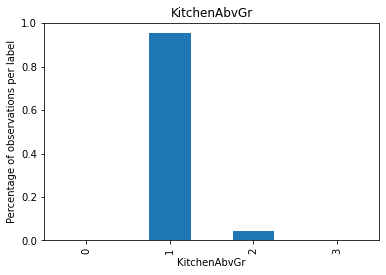

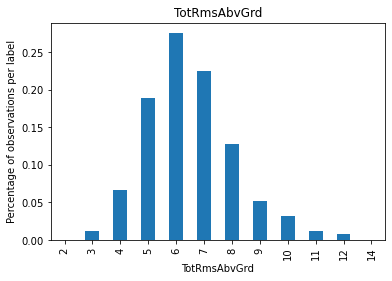

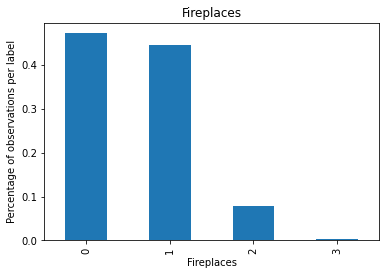

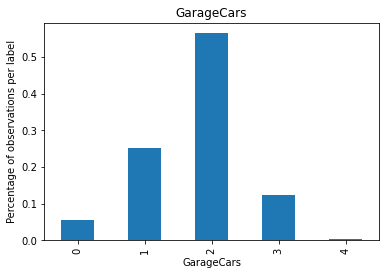

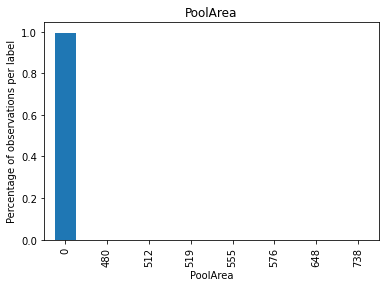

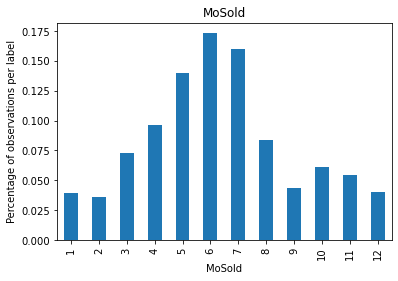

In [52]:
# outlies in discrete variables

for var in discrete:
    (data.groupby(var)[var].count() / float(len(data))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

Most of the discrete variables show values that are shared by a tiny proportion of houses in the dataset.

### Monotonicity between discrete variables and target values

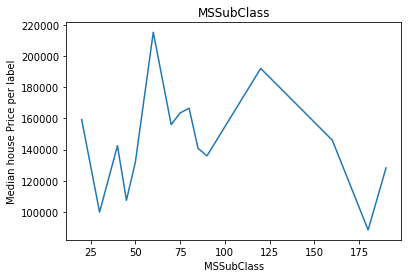

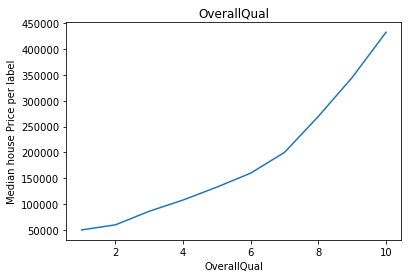

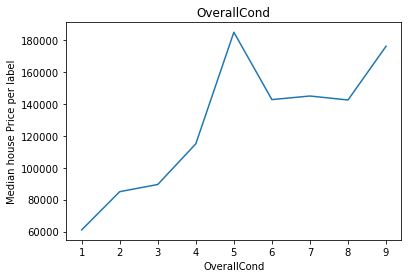

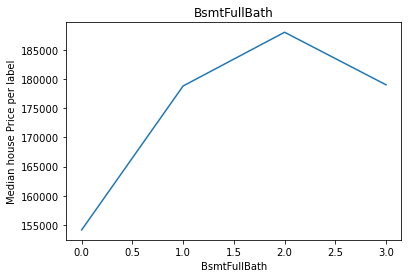

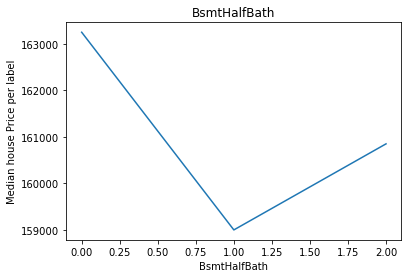

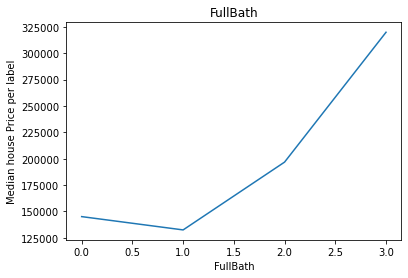

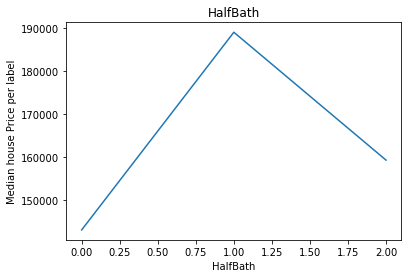

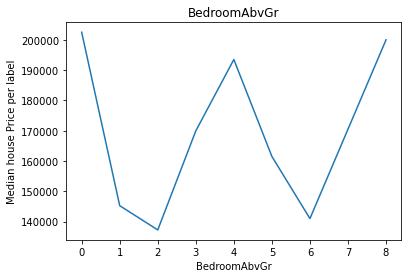

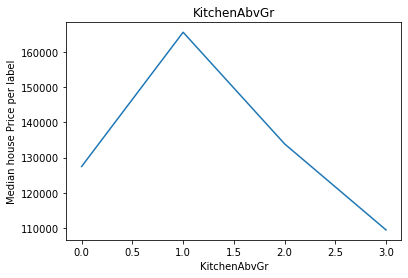

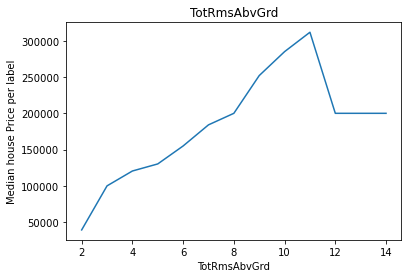

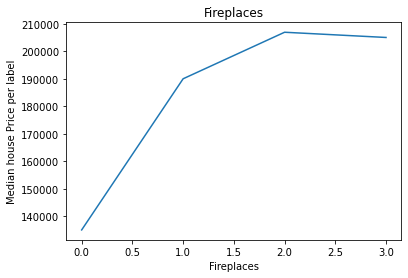

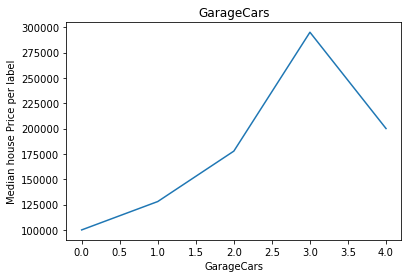

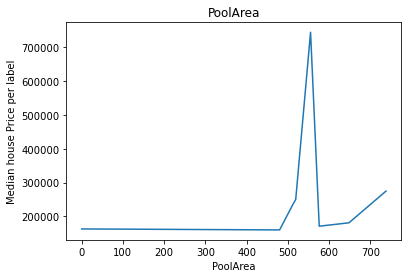

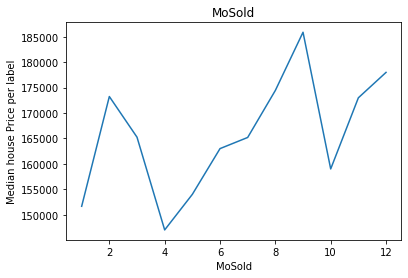

In [53]:
# Let's plot the median sale price per value of the discrete variable

for var in discrete:
    data.groupby(var)['SalePrice'].median().plot()
    plt.ylabel('Median house Price per label')
    plt.title(var)
    plt.show()

Some of the discrete variables show some sort of monotonic relationship and some don't.

#### Number of labels: cardinality

Let's go ahead now and examine the cardinality of our categorical variables. That is, the number of different labels.

Text(0, 0.5, 'Number of different categories')

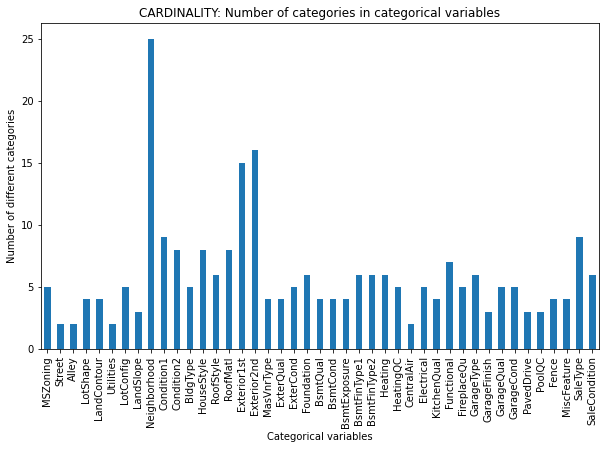

In [54]:
# plot number of categories per categorical variable

data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

Most of the variables, contain only a few labels. Then, we do not have to deal with high cardinality. That is good news!

Very likely though, they contain rare labels.

### Separate train and test set

In [55]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Id', 'SalePrice'], axis=1),
                                                    data['SalePrice'],
                                                    test_size=0.1,
                                                    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

#### Temporal variables

Because we have temporal variables we should calculate the time passed between the year variable and the time the house was sold.

In [56]:
# function to calculate elapsed time

def elapsed_years(df, var):
    """
    Capture difference between year variable and
    year the house was sold
    """
    
    df[var] = df['YrSold'] - df[var]
    return df

In [57]:
# Loop to implement the new values to the datasets.
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [58]:
X_train[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
930,2,2,2.0
656,49,2,49.0
45,5,5,5.0
1348,9,9,9.0
55,44,44,44.0


Instead of the "year", now we have the amount of **years that passed** since the house was built or remodeled and the house was sold. Next, we drop the YrSold variable from the datasets, because we already extracted its value.

In [59]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [60]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

### Missing data imputation
#### Continuous variables

In [61]:
# Print variables with missing data. Let's  keep in mind that now that we created those new temporal variables, we
# are going to treat them as numerical and continuous:

# Remove YrSold from the variable list because it is no longer in our dataset
year_vars.remove('YrSold')

# examine percentage of missing values
for col in numerical+year_vars:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

LotFrontage 0.17732115677321156
MasVnrArea 0.0045662100456621
GarageYrBlt 0.0563165905631659


Imputation technique to use: **additional variable with NA + median imputation**

In [62]:
# print variables with missing data

for col in categorical:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())
    

Alley 0.9383561643835616
MasVnrType 0.0045662100456621
BsmtQual 0.0243531202435312
BsmtCond 0.0243531202435312
BsmtExposure 0.02511415525114155
BsmtFinType1 0.0243531202435312
BsmtFinType2 0.02511415525114155
Electrical 0.00076103500761035
FireplaceQu 0.4726027397260274
GarageType 0.0563165905631659
GarageFinish 0.0563165905631659
GarageQual 0.0563165905631659
GarageCond 0.0563165905631659
PoolQC 0.9954337899543378
Fence 0.8143074581430746
MiscFeature 0.9611872146118722


# Putting it all together

In [63]:
# I will treat discrete variables as if they were categorical to treat discrete as categorical using Feature-engine.
# We need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [70]:
house_pipe = Pipeline([

    # missing data imputation - section 4
    ('missing_ind',
     mdi.AddMissingIndicator(
         missing_only = True,
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),

    ('imputer_num',
     mdi.MeanMedianImputer(
         imputation_method='median',
         variables=['LotFrontage', 'MasVnrArea', 'GarageYrBlt'])),

    ('imputer_cat', 
     mdi.CategoricalImputer(variables=categorical, imputation_method= 'missing')),

    # categorical encoding - section 6
    ('rare_label_enc',
     ce.RareLabelEncoder(tol=0.0087, n_categories=1, variables=discrete + categorical)),

    # newly available categorical encoder, uses trees predictions
    ('categorical_enc_categorical',
     ce.DecisionTreeEncoder(random_state=0, encoding_method='arbitrary', variables=categorical)),

    ('categorical_enc_discrete',
     ce.DecisionTreeEncoder(random_state=0, encoding_method='ordered', variables=discrete)),

    # discretisation - section 8
    ('discretisation',
     dsc.DecisionTreeDiscretiser(random_state=0, variables=numerical)),

    # feature Scaling - section 10
    ('scaler', StandardScaler()),

    # regression
    ('lasso', Lasso(random_state=0))
])

In [71]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

In [72]:
# a peek into the prediction values
X_train_preds

array([236581.58365683, 153685.24622533, 291764.34942263, ...,
       120193.07987245, 203554.25095052, 225547.21374037])

In [73]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 569780984.1290041
train rmse: 23870.085549260275
train r2: 0.908744982986095

test mse: 894161654.1837555
test rmse: 29902.53591560013
test r2: 0.8698855276888611


Text(0, 0.5, 'Predicted Price')

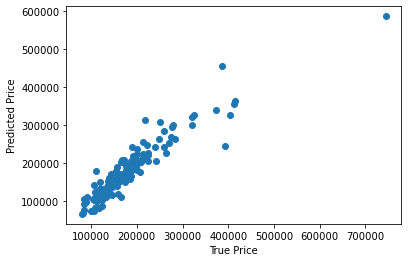

In [74]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

<AxesSubplot:>

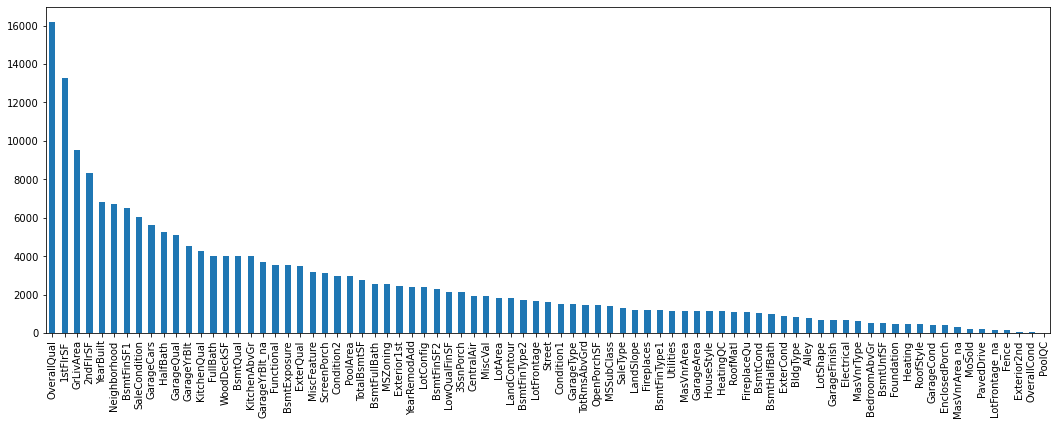

In [75]:
# Let's explore the importance of the features
# the importance is given by the absolute value of the coefficient assigned by the Lasso

importance = pd.Series(np.abs(house_pipe.named_steps['lasso'].coef_))
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))